In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftn, ifftn

# GRF generator for random input functions
def GRF(alpha, beta, gamma, N, num_samples=10):
    xi = np.random.randn(num_samples, N, N)
    K1, K2 = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    freq_sq = (K1**2 + K2**2)
    coef = alpha**0.5 * (4*np.pi**2 * freq_sq + beta)**(-gamma/2)
    L = N * coef * xi
    L[:, 0, 0] = 0  # enforce mean 0
    f_spatials = np.real(ifftn(L, norm='forward', axes=(-2, -1)))
    return f_spatials

# Dataset generation
def make_simple_learnable_operator_dataset(num_samples=25, H=64, W=64, sigma=1.0, seed=0):
    np.random.seed(seed)
    y = np.arange(H)
    x = np.arange(W)
    Y, X = np.meshgrid(y, x, indexing='ij')
    center_y = (H - 1) / 2
    center_x = (W - 1) / 2
    dist_sq = (X - center_x)**2 + (Y - center_y)**2
    f0 = np.exp(-dist_sq / (2 * (H/8)**2))
    f0 /= np.linalg.norm(f0)

    kernel_spatial = np.exp(-dist_sq / (2 * sigma**2))
    kernel_spatial /= np.sum(kernel_spatial)
    kernel_hat = fft2(kernel_spatial)
    f0_hat = fft2(f0)
    conv_f0 = ifft2(kernel_hat * f0_hat).real

    alpha, beta, gamma, N = 1.0, 1.0, 4.0, H
    fs = GRF(alpha, beta, gamma, N, num_samples)

    Ofs = np.array([
        np.sum(f_i * f0) * conv_f0
        for f_i in fs
    ])

    return fs, Ofs, f0

# Generate data
icl_num_samples = 100
f, Of, f0 = make_simple_learnable_operator_dataset(num_samples=icl_num_samples)

# Split into train and test
f_train  = f[:-1]
Of_train = Of[:-1]
f_test   = f[-1]
Of_test  = Of[-1]

# Linear regression in operator RKHS
# Model: O_hat(f) = sum_i alpha_i * <f, f_i> * conv_f0

# Precompute inner products <f_train[i], f_train[j]>
T, H, W = f_train.shape
gram = np.array([
    [np.sum(f_train[i] * f_train[j]) for j in range(T)]
    for i in range(T)
])

print(gram)

# # Flatten training outputs
# Y = Of_train.reshape(T, -1)  # shape (T, H*W)

# # Solve (G + lambda I) alpha = Y for each pixel
# G_reg = gram
# alpha = np.linalg.solve(G_reg, Y)  # shape (T, H*W)

# # Predict Of_test
# test_inner_prods = np.array([np.sum(f_test * f_train[i]) for i in range(T)])  # shape (T,)
# Of_test_pred_flat = test_inner_prods @ alpha  # shape (H*W,)
# Of_test_pred = Of_test_pred_flat.reshape(H, W)

# # Retry with fewer steps and more efficient updates
# alpha_gd = np.zeros((T, H * W))
# lr = 1e-2
# num_steps = 1
# max_grad_norm = 1e2

# losses = []

# for step in range(num_steps):
#     residual = gram @ alpha_gd - Y
#     grad     = gram.T @ residual
#     alpha_gd -= lr * grad

#     loss = 0.5 * np.linalg.norm(residual)**2
#     losses.append(loss)

# # Predict using GD solution
# Of_test_pred_gd_flat = test_inner_prods @ alpha_gd
# Of_test_pred_gd = Of_test_pred_gd_flat.reshape(H, W)

# # Plot comparison
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].imshow(Of_test, cmap='viridis')
# axes[0].set_title("Ground Truth: O f_test")
# axes[0].axis('off')

# axes[1].imshow(Of_test_pred, cmap='viridis')
# axes[1].set_title("Closed-Form RKHS Prediction")
# axes[1].axis('off')

# axes[2].imshow(Of_test_pred_gd, cmap='viridis')
# axes[2].set_title("Gradient Descent Prediction")
# axes[2].axis('off')

# plt.tight_layout()
# plt.show(), losses[-1]

[[  0.66982269   0.30565652  -2.89082631 ...  -0.13609804   2.25097297
    0.567708  ]
 [  0.30565652   2.56721684  -0.59033589 ...   2.60644459  -4.0436175
   -0.34904803]
 [ -2.89082631  -0.59033589  13.47227709 ...   1.62908326 -12.67281417
   -3.00530584]
 ...
 [ -0.13609804   2.60644459   1.62908326 ...   3.26099439  -7.23953002
   -1.11365655]
 [  2.25097297  -4.0436175  -12.67281417 ...  -7.23953002  23.63094749
    4.69175789]
 [  0.567708    -0.34904803  -3.00530584 ...  -1.11365655   4.69175789
    1.07354289]]


In [2]:
from opformer import TransformerOperator
import torch

device = "cuda"

im_size = (64, 64)
opformer = TransformerOperator(num_layers=5, im_size=im_size, icl_init=True, sigma=1.0).to(device)

In [3]:
Z = np.expand_dims(np.concatenate([f, Of], axis=1), axis=0)
Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
y_test = Z_pt[:,-1,im_size[0]//2:].clone().cpu().numpy()
Z_pt[:,-1,im_size[0]//2:] = 0

pred_opformer = opformer(Z_pt)
pred_opformer = pred_opformer.cpu().detach().numpy()

tensor([[[[ 1.6353e-04,  7.4623e-05, -7.0577e-04,  ...,  5.4955e-04,
            1.3860e-04, -1.9199e-04],
          [ 7.4623e-05,  6.2676e-04, -1.4412e-04,  ..., -9.8721e-04,
           -8.5217e-05, -4.5000e-05],
          [-7.0577e-04, -1.4412e-04,  3.2891e-03,  ..., -3.0939e-03,
           -7.3372e-04,  9.2420e-04],
          ...,
          [ 5.4955e-04, -9.8721e-04, -3.0939e-03,  ...,  5.7693e-03,
            1.1454e-03, -9.6485e-04],
          [ 1.3860e-04, -8.5217e-05, -7.3372e-04,  ...,  1.1454e-03,
            2.6210e-04, -2.3388e-04],
          [-1.9199e-04, -4.5000e-05,  9.2420e-04,  ..., -9.6485e-04,
           -2.3388e-04,  5.4901e-04]]]], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([[[[ 0.0007,  0.0003, -0.0028,  ...,  0.0022,  0.0006, -0.0008],
          [ 0.0003,  0.0025, -0.0006,  ..., -0.0039, -0.0003, -0.0002],
          [-0.0028, -0.0006,  0.0132,  ..., -0.0124, -0.0029,  0.0037],
          ...,
          [ 0.0022, -0.0039, -0.0124,  ...,  0.0231,  0.0046,

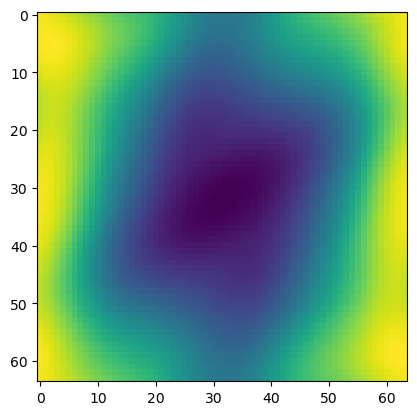

In [18]:
plt.imshow(f_train[0])

In [10]:
q = np.load("q.npy")[0,0]
k = np.load("k.npy")[0,0]

kx = np.matmul(q, k.transpose(-1, -2))

print(q.shape)
print(k.shape)

(100, 4096)
(100, 4096)


In [19]:
q[0]

array([0.33221892, 0.330316  , 0.32458422, ..., 0.32185775, 0.32915482,
       0.33307165], dtype=float32)

In [20]:
f_train[0]

array([[0.02076368, 0.02064476, 0.02028652, ..., 0.01971395, 0.02028652,
        0.02064476],
       [0.0208133 , 0.02081698, 0.02057218, ..., 0.01940694, 0.02009468,
        0.02056749],
       [0.0209505 , 0.02106629, 0.02092099, ..., 0.01919044, 0.01998613,
        0.0205771 ],
       ...,
       [0.0211332 , 0.0206496 , 0.01993822, ..., 0.02098952, 0.02126928,
        0.02133211],
       [0.0209505 , 0.0205771 , 0.01998613, ..., 0.02056288, 0.02092099,
        0.02106629],
       [0.0208133 , 0.02056749, 0.02009468, ..., 0.02011611, 0.02057218,
        0.02081698]])